In [1]:
import math
import sys,os
import datetime
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
ds = xr.open_dataset('ww3/LOPS_WW3-GLOB-30M_202001.nc')

In [3]:
# get lm, convert to numpy and reshape over 1D
lm = ds.lm[10,:,:].compute().values.reshape(-1)
hs = ds.hs[10,:,:].compute().values.reshape(-1)
dir = ds.dir[10,:,:].compute().values.reshape(-1)
spr = ds.spr[10,:,:].compute().values.reshape(-1)
t01 = ds.t01[10,:,:].compute().values.reshape(-1)
t02 = ds.t02[10,:,:].compute().values.reshape(-1)
t0m1 = ds.t0m1[10,:,:].compute().values.reshape(-1)

In [4]:
#get first 100 values
lat = list(ds.latitude[:].values)
lon = list(ds.longitude[:].values)

In [5]:
lenlat=len(lat)
lenlon=len(lon)

In [6]:
# duplicate over lat or lon dimensions
lon = lon*lenlat
lat = np.repeat(lat,lenlon)

In [7]:
xx = np.empty([hs.shape[0],10])

In [8]:
xx[:,0] = 0
xx[:,1] = lat
xx[:,2] = lon
xx[:,3] = hs
xx[:,4] = lm
xx[:,5] = dir
xx[:,6] = spr
xx[:,7] = t01
xx[:,8] = t02
xx[:,9] = t0m1

In [9]:
# remove all lines where there is NaN
all=xx[~np.isnan(xx).any(axis=1),:]

In [20]:
# keep only hs > 5m for strom
# set to 0 if hs<5m, otherwise to 1 if hs > 5m
# x=all[all[:,2]>5]
x=all
x[:,0]=np.where(x[:,3]>5,x[:,0]*0,(x[:,0]*0)+1)

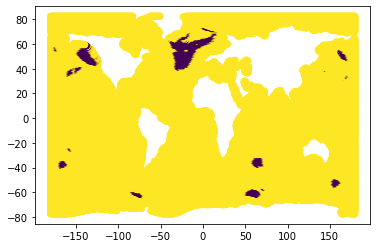

In [29]:
plt.scatter(x[:,2],x[:,1],c=x[:,0])

In [30]:
# faire un random forest avec toutes les variables du modèle
# pour voir lesquelles sont pertinentes et ensuite faire un ACP ou KMEANS

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf = RandomForestClassifier(
    n_estimators =100,
    max_depth = 2,
    min_samples_split = 5,
    max_features = 2,
    oob_score=True)

In [33]:
# fit par rapport à la colonne 0 (storm flag)
rf.fit(x[:,3:],x[:,0])

RandomForestClassifier(max_depth=2, max_features=2, min_samples_split=5,
                       oob_score=True)

In [34]:
#rf.predict(x)

In [39]:
rf.score(x[:,3:],x[:,0])

0.9988231022523819

In [41]:
rf.feature_importances_

array([0.62613633, 0.01620239, 0.00688255, 0.05582098, 0.10187842,
       0.15221214, 0.04086719])

<BarContainer object of 7 artists>

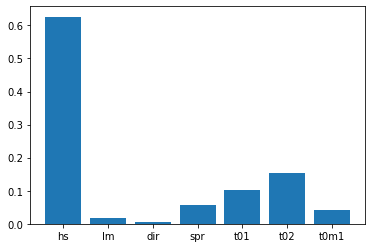

In [44]:
#hs lm dir spr t01 t02 t0m1
import matplotlib.pyplot as plt
plt.bar(["hs","lm","dir","spr","t01","t02","t0m1"],rf.feature_importances_)

In [45]:
# faire un pareto
# puis un acp pour voir la pertinence des variables
# test 1 faire une regression multivariée

In [46]:
from sklearn.decomposition import PCA

In [47]:
def pareto(data) :

    from matplotlib.ticker import PercentFormatter

    import numpy as np

    y = list(data)

    x = range(len(data))

    ycum = np.cumsum(y)/sum(y)*100

    fig, ax = plt.subplots()

    ax.bar(x,y,color="yellow")

    ax2 = ax.twinx()

    ax2.plot(x,ycum, color="C1", marker="D", ms=7)

    ax2.axhline(y=80,color="r")

    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax.tick_params(axis="y", colors="C0")

    ax2.tick_params(axis="y", colors="C1")

    plt.ylim(0,110)

    plt.show()

In [54]:
# centre reduit
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
ss.fit(x)
xsc=ss.transform(x)

In [62]:
# test with my components
acp = PCA(n_components=4)
acp.fit(xsc[:,[3,6,7,8]])
prediction = acp.transform(xsc[:,[3,6,7,8]])

In [63]:
prediction

array([[-2.2465266 , -0.15386521, -0.54622712, -0.07635675],
       [-2.31860834, -0.04348995, -0.48873575, -0.0876447 ],
       [-2.33562857, -0.0600116 , -0.50337465, -0.08760358],
       ...,
       [ 2.44709439,  2.72569386, -1.58964345,  1.1334765 ],
       [ 2.60395501,  2.79461845, -1.61455887,  1.1141637 ],
       [ 2.77151799,  2.86634786, -1.6419325 ,  1.08888205]])

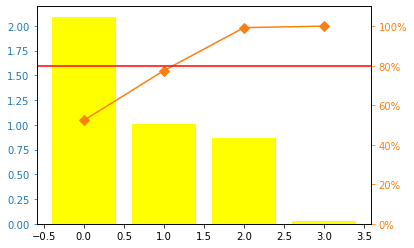

In [56]:
pareto(acp.explained_variance_)

/tmp/ipykernel_438109/2889482840.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


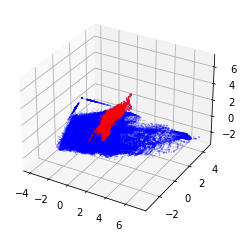

In [71]:
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
ind_tp = np.where(x[:,0]==0)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(prediction[:,0],prediction[:,1],prediction[:,2],c="blue",s=0.1)
ax.scatter(prediction[ind_tp,0],prediction[ind_tp,1],prediction[ind_tp,2],c="red",s=0.2)
plt.show()

In [65]:
%matplotlib inline

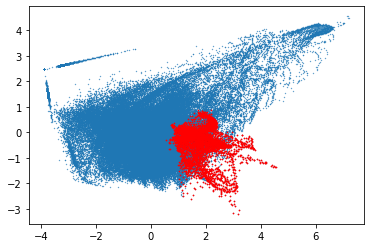

In [68]:
import matplotlib.pyplot as plt
ind_tp = np.where(x[:,0]==0)
plt.scatter(prediction[:,0],prediction[:,1],s=0.1)
plt.scatter(prediction[ind_tp,0],prediction[ind_tp,1],c="red",s=0.5)

[2 2 2 ... 4 4 4]


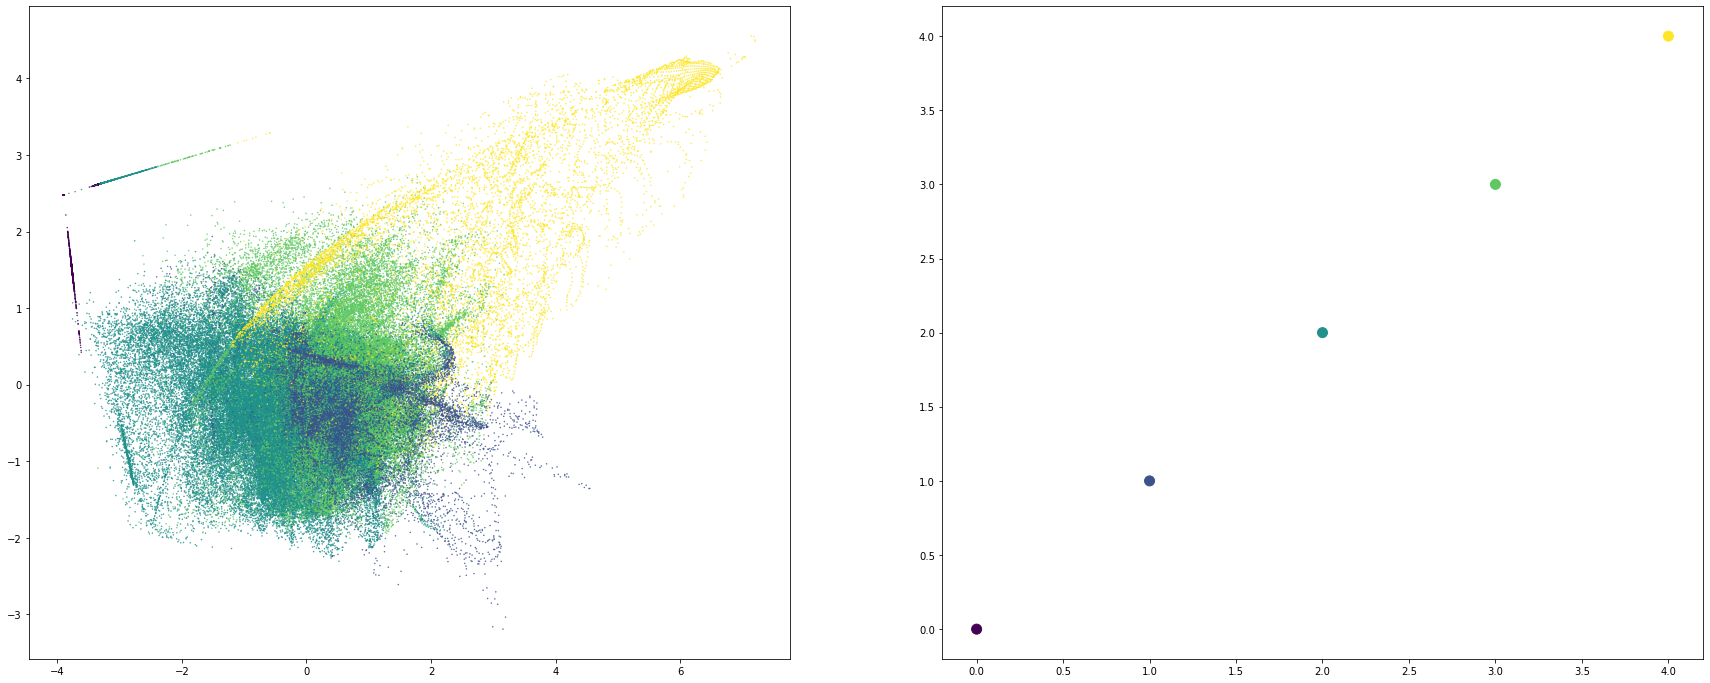

In [81]:
# gaussian mixture pour regrouper les tempetes en mieux !
from sklearn.mixture import GaussianMixture

# instanciation
gm = GaussianMixture( n_components=5)

# ajustement
gm.fit(xsc[:,[3,6,7,8]])

# prediction
labels=gm.predict(xsc[:,[3,6,7,8]])
print(labels)
fig, ax = plt.subplots(figsize=(30, 12)) 
plt.subplot(121)
plt.scatter(prediction[:,0],prediction[:,1],c=labels,s=0.2)
plt.subplot(122)
plt.scatter(range(5),range(5),c=range(5),s=100)
#plt.scatter(prediction[ind_tp,0],prediction[ind_tp,1],c=labels,s=0.1)

/tmp/ipykernel_438109/3194164361.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


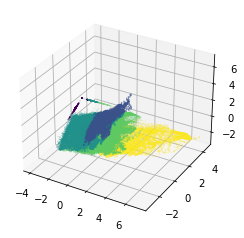

In [85]:
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
ind_tp = np.where(x[:,0]==0)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(prediction[:,0],prediction[:,1],prediction[:,2],c=labels,s=0.1)
#ax.scatter(prediction[ind_tp,0],prediction[ind_tp,1],prediction[ind_tp,2],c="red",s=0.2)
plt.show()

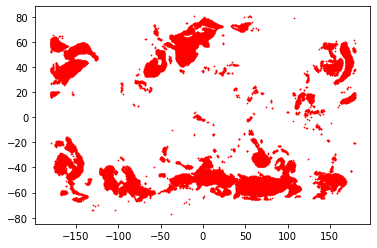

In [84]:
# afficher la nouvelle categorisation fournit pas gaussian mixture
code = 1 # valable que si comptabile figure précédente
ind_tp2 = np.where(labels == code)
plt.scatter(x[ind_tp2,2],x[ind_tp2,1],c="red",s=0.5)

In [109]:
# Régression linéaire
import statsmodels.formula.api as sm
import pandas as pd
df = pd.DataFrame(x[:,[3,6,7,8]], columns = ['hs','spr','t01','t02'])

In [110]:
labels = np.repeat(0,len(labels))
labels[ind_tp2] = 1

In [111]:
df=pd.concat([df,pd.Series(labels)],axis=1)
df.columns.values[4] = "labels"

In [112]:
df.head()
df.labels

0         0
1         0
2         0
3         0
4         0
         ..
159737    0
159738    0
159739    0
159740    0
159741    0
Name: labels, Length: 159742, dtype: int64

(array([132160.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  27582.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

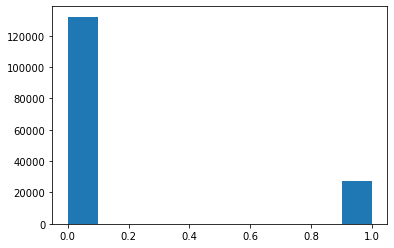

In [113]:
plt.hist(df.labels)

In [114]:
# regression
model= sm.ols(formula='labels~hs+spr+t01+t02',data=df)
reg= model.fit()
# Avec sklearn
#from sklearn.linear_models import LinearRegression
#reg = LinearRegression()
#reg.fit(X=x[:,[3,6,7,8]],y=labels)

In [115]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 labels   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                 2.160e+04
Date:                Fri, 26 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:35:59   Log-Likelihood:                -36706.
No. Observations:              159742   AIC:                         7.342e+04
Df Residuals:                  159737   BIC:                         7.347e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0721      0.003     23.209      0.000       0.066       0.078
hs             0.1633      0.001    277.993      0.000       0.162       0.164
spr           -0.0029   4.87e-05    -59.827      0.000      -0.003      -0.003
t01           -0.0854      0.001    -71.828      0.000      -0.088      -0.083
t02            0.0798      0.001     62.315      0.000       0.077       0.082
==============================================================================
Omnibus:                    24775.728   Durbin-Watson:                   0.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38126.545
Skew:                           1.125   Prob(JB):                         0.00
Kurtosis:                       3.815   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

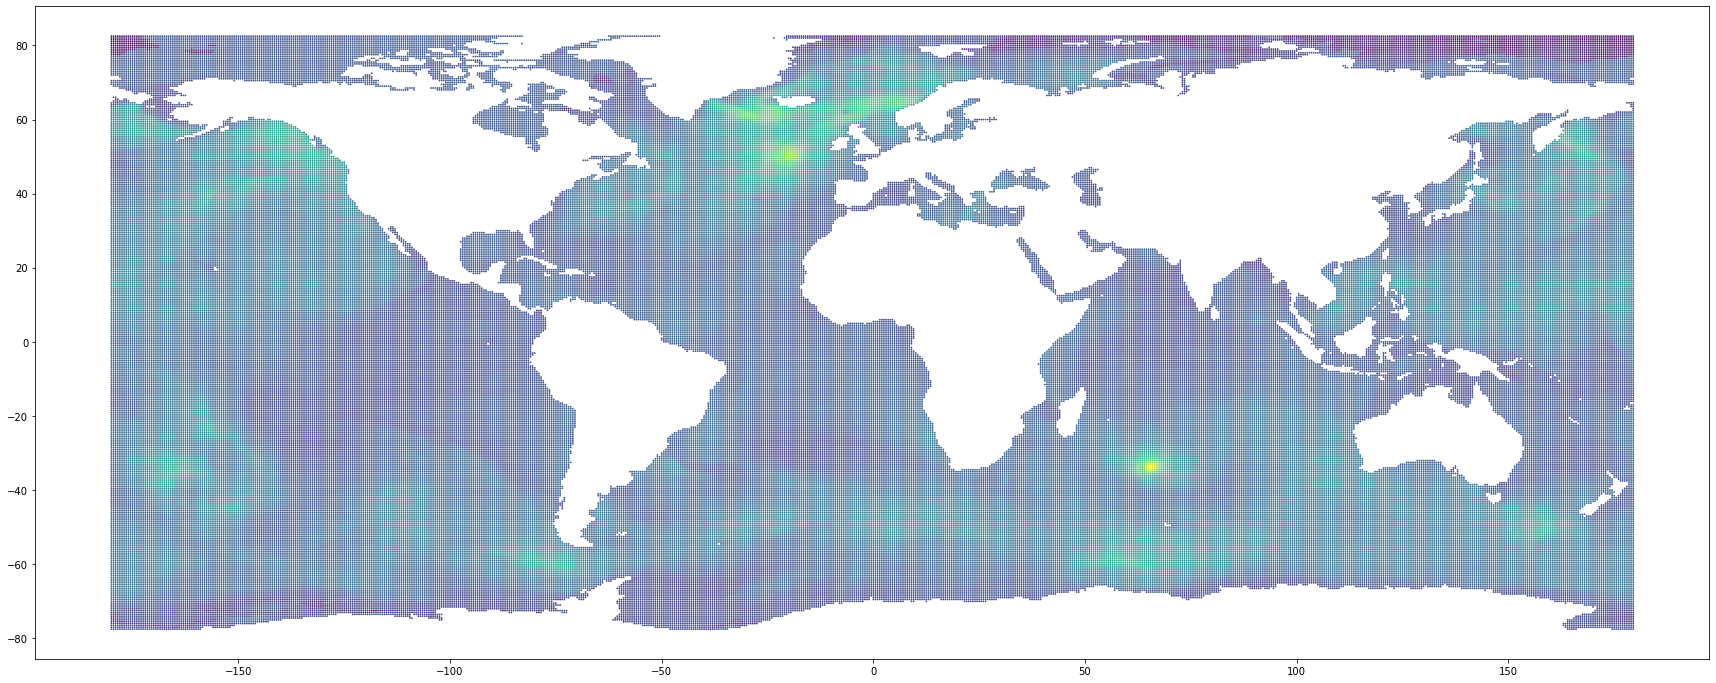

In [117]:
# afficher la nouvelle categorisation fournit pas gaussian mixture
fig, ax = plt.subplots(figsize=(30, 12)) 
plt.scatter(x[:,2],x[:,1],c=reg.predict(df),s=0.5)

(array([2.3530e+03, 7.6550e+03, 7.2889e+04, 5.8072e+04, 1.4074e+04,
        3.4420e+03, 9.2900e+02, 2.8500e+02, 2.9000e+01, 1.4000e+01]),
 array([-0.59666042, -0.34544441, -0.0942284 ,  0.15698761,  0.40820361,
         0.65941962,  0.91063563,  1.16185163,  1.41306764,  1.66428365,
         1.91549966]),
 <BarContainer object of 10 artists>)

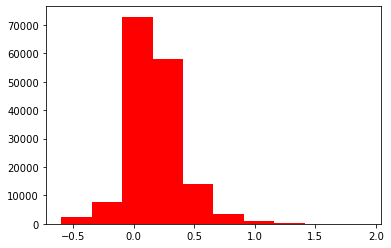

In [118]:
plt.hist(reg.predict(df),color="red")